In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
import transformers
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
from torch import nn
import torch.nn.functional as F
#from tqdm import trange
from tqdm.notebook import tqdm, trange
import os
from transformers import AdamW, get_linear_schedule_with_warmup
import nlpaug

cuda


In [2]:
rev = pd.read_json('yelp_review_training_dataset.jsonl',lines=True)

In [3]:
rev.head()

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1


In [4]:
rev.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533581 entries, 0 to 533580
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  533581 non-null  object
 1   text       533581 non-null  object
 2   stars      533581 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 12.2+ MB


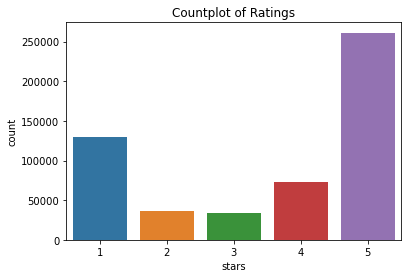

In [5]:
all_ratings = rev['stars']
plt.title('Countplot of Ratings')
sns.countplot(x=all_ratings);

### Our data is not evenly split, with more polarizing reviews being the most popular. Postively rated restaurants are rated the highest

### We must now clean our review data to perform analysis on it

In [6]:
def clean_text(text_data):
    text_data = text_data.lower()
    #text_data = re.sub('\w*\d\w*', "", text_data)
    return text_data    

In [7]:
rev['clean_text'] = rev.text.apply(lambda x: clean_text(x))

In [8]:
rev.head()

,review_id,text,stars,clean_text
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1,total bill for this horrible service? over $8g...
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5,i *adore* travis at the hard rock's new kelly ...
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5,i have to say that this office really has it t...
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5,went in for a lunch. steak sandwich was delici...
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1,today was my second out of three sessions i ha...


### Baseline model (simple LR)

In [9]:
X = rev['clean_text']
y = rev['stars']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.4, random_state=123)


In [10]:
tfid = TfidfVectorizer(max_df = 10000, use_idf=True)
tfid.fit_transform(X_train)
X_train_vec = tfid.transform(X_train)
X_val_vec = tfid.transform(X_val)
X_test_vec = tfid.transform(X_test)

In [19]:
X_train_vec.shape, X_val_vec.shape, X_test_vec.shape

((480222, 183709), (32015, 183709), (21344, 183709))

In [20]:
lr_accuracies = []
for c in [0.001, 0.01, 0.1, 1, 10, 100]:
    lr = LogisticRegression(max_iter=10000, C=c, solver='liblinear')
    lr.fit(X_train_vec, y_train)
    prediction = lr.predict(X_val_vec)
    #amount of non 5 predictions
    #print(len(np.where(np.array(prediction) != 5)[0]))
    print('Accuracy is: ', accuracy_score(prediction, y_val))
    lr_accuracies.append(accuracy_score(prediction, y_val))
    print('Precision is: ', precision_score(prediction, y_val, average='weighted'))
    print('Recall is: ', recall_score(prediction, y_val, average='weighted'))

Accuracy is:  0.4903638919256598
Precision is:  0.9997503441514224
Recall is:  0.4903638919256598
Accuracy is:  0.6305794158987974
Precision is:  0.90679863401919
Recall is:  0.6305794158987974
Accuracy is:  0.6928002498828674
Precision is:  0.8550445358885731
Recall is:  0.6928002498828674
Accuracy is:  0.7115727002967359
Precision is:  0.8250700204408503
Recall is:  0.7115727002967359
Accuracy is:  0.7028267999375293
Precision is:  0.7867032929432922
Recall is:  0.7028267999375293
Accuracy is:  0.6822114633765423
Precision is:  0.7409117631730839
Recall is:  0.6822114633765423


In [24]:
#max occurs at c value of 1
lr_accuracies

[0.4903638919256598,
 0.6305794158987974,
 0.6928002498828674,
 0.7115727002967359,
 0.7028267999375293,
 0.6822114633765423]

In [30]:
lr = LogisticRegression(max_iter=10000, C=1, solver='liblinear')
lr.fit(X_train_vec, y_train)
prediction = lr.predict(X_test_vec)
accuracy = accuracy_score(prediction, y_test)
print('Final Test Accuracy: ', accuracy)
print('Precision is: ', precision_score(prediction, y_test, average='weighted'))
print('Recall is: ', recall_score(prediction, y_test, average='weighted'))

Final Test Accuracy:  0.7110194902548725
Precision is:  0.8232197850619091
Recall is:  0.7110194902548725


In [39]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
confusion_matrix

array([[4421,   98,   52,   57,  588],
       [ 836,  150,  103,  123,  263],
       [ 298,   92,  155,  345,  477],
       [ 165,   25,   80,  756, 1841],
       [ 257,   10,   27,  431, 9694]], dtype=int64)

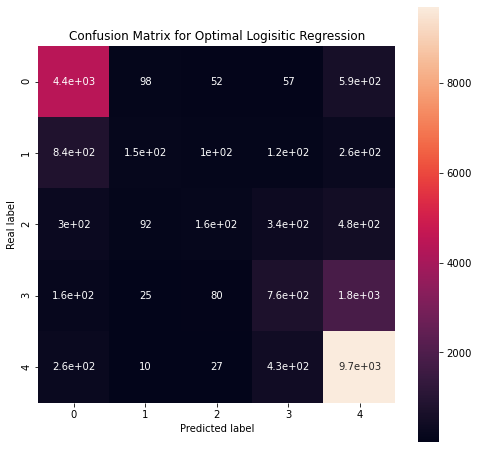

In [45]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, square = True);
plt.ylabel('Real label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix for Optimal Logisitic Regression');
plt.savefig('confusion_matrix_LR.png')

In [46]:
example = ['this place is SUCKS and i hate it']
example_vec = tfid.transform(example)
prediction_e = lr.predict(example_vec)
prediction_e

array([1], dtype=int64)

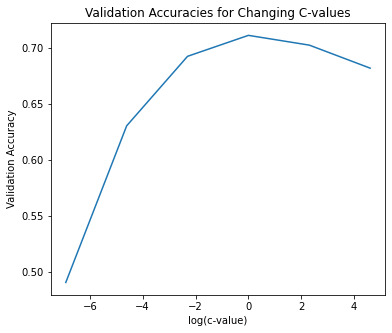

In [57]:
plt.figure(figsize=(6,5))
c_vals = [0.001, 0.01, 0.1, 1, 10, 100]
plt.plot(np.log(c_vals), lr_accuracies);
plt.xlabel('log(c-value)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies for Changing C-values');
plt.savefig('validation_acc_LR')

### We will now begin the use of the BERT model. First we will consider it on the filtered text, so uncased data. Then we will consider it on cased data. Potentially we can combine these 2 and average their predictions as our novel contribution.

In [16]:
from simpletransformers.classification import ClassificationModel, MultiLabelClassificationModel

In [26]:
model = MultiLabelClassificationModel('bert', 'bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not 

In [27]:
X_train_bert = rev.drop(columns={'review_id', 'text'})
#display(X_train_bert)
display(type(X_train_bert.iloc[0]['stars']))
X_train_bert = X_train_bert[['clean_text', 'stars']]
X_train_bert.head()



numpy.int64

,clean_text,stars
0,total bill for this horrible service? over $. ...,1
1,i *adore* travis at the hard rock's new kelly ...,5
2,i have to say that this office really has it t...,5
3,went in for a lunch. steak sandwich was delici...,5
4,today was my second out of three sessions i ha...,1


### Real BERT

In [10]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
class ProcessData(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len, labels):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.labels = labels
    
    def __getitem__(self, index):
        review = self.data[index]
        label = self.labels[index]
        return self.tokenizer.encode_plus(review, max_length=self.max_len, padding='max_length', return_attention_mask=True, return_tensors='pt', truncation=True), review, torch.tensor([label-1]).to(torch.long)
    
    def __len__(self):
        review_length = len(self.data)
        return review_length

In [12]:
tokenized_training_data = ProcessData(X_train.to_numpy().tolist(), tokenizer, 150, y_train.to_numpy())
tokenized_validation_data = ProcessData(X_val.to_numpy().tolist(), tokenizer, 150, y_val.to_numpy())
tokenized_test_data = ProcessData(X_test.to_numpy().tolist(), tokenizer, 150, y_test.to_numpy())

In [13]:
tokenized_training_data[0][0], tokenized_training_data[0][1], tokenized_training_data[0][2]

({'input_ids': tensor([[  101,  1045,  2001,  2559,  2005,  1037,  2047, 13362, 22231,  2361,
           1998,  1045,  1005,  2310,  2179,  2009,  1012,  1045,  2288,  1037,
           2307,  2606, 12690,  1998,  2307,  2326,  2182,  1010,  1045,  3811,
          16755,  2023,  2173,  1012,  1045,  1005,  2222,  2022,  2067,   102,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,   

In [14]:
#Create dataloader
params = {'batch_size': 32,
          'num_workers': 0}
loader_tokenized_training_data = torch.utils.data.DataLoader(tokenized_training_data, **params)
loader_tokenized_validation_data = torch.utils.data.DataLoader(tokenized_validation_data, **params)
loader_tokenized_test_data = torch.utils.data.DataLoader(tokenized_test_data, **params)

In [15]:
bert = transformers.BertModel.from_pretrained('bert-base-uncased')

In [16]:
X_train[0], y_train[0]

('total bill for this horrible service? over $8gs. these crooks actually had the nerve to charge us $69 for 3 pills. i checked online the pills can be had for 19 cents each! avoid hospital ers at all costs.',
 1)

In [17]:
ex = tokenizer.encode_plus(X_train[0], max_length=100, padding='max_length', return_attention_mask=True, return_tensors='pt', truncation=True)

In [18]:
ex

{'input_ids': tensor([[  101,  2561,  3021,  2005,  2023,  9202,  2326,  1029,  2058,  1002,
          1022,  5620,  1012,  2122, 19302,  2015,  2941,  2018,  1996,  9113,
          2000,  3715,  2149,  1002,  6353,  2005,  1017, 15345,  1012,  1045,
          7039,  3784,  1996, 15345,  2064,  2022,  2018,  2005,  2539, 16653,
          2169,   999,  4468,  2902,  9413,  2015,  2012,  2035,  5366,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

In [19]:
#https://huggingface.co/transformers/main_classes/output.html
#output = bert(**ex)

In [20]:
#output[0].shape, output[1].shape

### Training BERT model

In [21]:
class BERTNet(nn.Module):
    def __init__(self, classes):
        super(BERTNet, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.linear = nn.Linear(768, classes)
        self.sm = nn.Softmax(dim=1)
    
    def forward(self, input_ids, attention_mask):
        #print(input_ids,attention_mask )
        output = self.bert_model(input_ids, attention_mask)
        output = output[1]
        output = self.drop(output)
        output = self.linear(output)
        return output

In [22]:
model = BERTNet(5).to(device)
#model = model.to(device)
#ex = ex.to(device)
#ex['input_ids'] = ex['input_ids'].to(device)
#ex['attention_mask'] = ex['attention_mask'].to(device)
#ex['token_type_ids'] = ex['token_type_ids'].to(device)

In [23]:
#model(ex['input_ids'], ex['attention_mask'])

In [24]:
#ex

In [25]:
#F.softmax(model(ex['input_ids'], ex['attention_mask']), dim=1)

In [26]:
from torch.optim import Adam
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=5e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=len(loader_tokenized_training_data) * 5)

In [27]:
def training(model, data_loader, size):
    model = model.train()
    losses = []
    training_acc = 0
    for data in tqdm(data_loader):
        batch_ids = data[0]['input_ids']
        batch_ids = batch_ids.flatten().reshape((batch_ids.shape[0], batch_ids.shape[2]))
        batch_masks = data[0]['attention_mask']
        batch_masks = batch_masks.flatten().reshape((batch_masks.shape[0], batch_masks.shape[2]))
        data[2] = data[2].to(device)
       
       
        output = model(batch_ids.to(device), batch_masks.to(device))
        #print(output)
     
        prediction = torch.max(output, 1)[1]
 
        training_loss = criterion(output, torch.flatten(data[2]))
        training_acc += torch.sum(prediction == torch.flatten(data[2]))
   
        losses.append(training_loss.item())
        training_loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return training_acc / size, np.mean(losses)

In [28]:
def evaluate(model, data_loader, size):
    model = model.eval()
    losses = []
    validation_acc = 0
    with torch.no_grad():
        for vdata in tqdm(data_loader):
            vbatch_ids = vdata[0]['input_ids']
            vbatch_ids = vbatch_ids.flatten().reshape((vbatch_ids.shape[0], vbatch_ids.shape[2]))
            vbatch_masks = vdata[0]['attention_mask']
            vbatch_masks = vbatch_masks.flatten().reshape((vbatch_masks.shape[0], vbatch_masks.shape[2]))
            vdata[2] = vdata[2].to(device)
           

            voutput = model(vbatch_ids.to(device), vbatch_masks.to(device))
            vprediction = torch.max(voutput, 1)[1]
            
            vloss = criterion(voutput, torch.flatten(vdata[2]))
            validation_acc += torch.sum(vprediction == torch.flatten(vdata[2]))
            losses.append(vloss.item())
    return validation_acc / size, np.mean(losses)

In [29]:
#len(loader_tokenized_training_data)
#a = next(iter(loader_tokenized_training_data))

In [30]:
PATH = 'C:/Users/Hardeep/Desktop/nlp_proj'

highest_acc = 0
for epoch in trange(5):
    print('Epoch: ' , str(epoch))
    print('==================================')
    training_accuracy, training_loss = training(model,loader_tokenized_training_data,len(X_train) )
    validation_accuracy, validation_loss = evaluate(model, loader_tokenized_validation_data, len(X_val))
    
    print('Training accuracy: ', training_accuracy )
    print('Training loss: ', training_loss)
    print('Validation accuracy: ', validation_accuracy)
    print('Validation loss: ', validation_loss)
    
    torch.save(model.state_dict(), os.path.join(PATH,'epoch'+str(epoch)+'full_data_model.pth'))
    #torch.save(model.state_dict(),‘mode.pth’, 'C:/Users/Hardeep/Desktop/nlp_proj')
    
    
    
            
        
        
        

Epoch:  0



Training accuracy:  tensor(0.7721, device='cuda:0')
Training loss:  0.5792807427494914
Validation accuracy:  tensor(0.7891, device='cuda:0')
Validation loss:  0.5294893460792975
Epoch:  1



Training accuracy:  tensor(0.8075, device='cuda:0')
Training loss:  0.4800368861484005
Validation accuracy:  tensor(0.7950, device='cuda:0')
Validation loss:  0.5261187923776282
Epoch:  2



Training accuracy:  tensor(0.8366, device='cuda:0')
Training loss:  0.40626750939265077
Validation accuracy:  tensor(0.7923, device='cuda:0')
Validation loss:  0.5627733429858497
Epoch:  3



Training accuracy:  tensor(0.8712, device='cuda:0')
Training loss:  0.3252521584234561
Validation accuracy:  tensor(0.7847, device='cuda:0')
Validation loss:  0.640250725956349
Epoch:  4



Training accuracy:  tensor(0.9021, device='cuda:0')
Training loss:  0.25358758564744777
Validation accuracy:  tensor(0.7840, device='cuda:0')
Validation loss:  0.7051204295752647



In [ ]:
tokenized_training_data[0][0]['input_ids'].flatten()
(tokenized_training_data[1][0]['input_ids'].flatten()).shape

In [33]:
test_acc, _ = evaluate(model, loader_tokenized_test_data, len(X_test))

In [34]:
test_acc

tensor(0.7863, device='cuda:0')

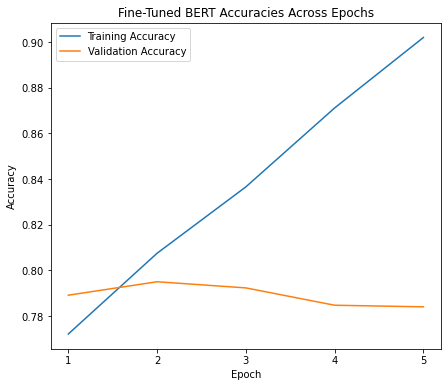

In [61]:
epoch_training_accs = [0.7721, 0.8075, 0.8366, 0.8712, 0.9021]
epoch_validation_accs = [0.7891, 0.7950, 0.7923, 0.7847, 0.7840]
epochs = [1,2,3,4,5]
plt.figure(figsize=(7,6));
plt.plot(epochs, epoch_training_accs );
plt.plot(epochs,epoch_validation_accs);
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch');
plt.xticks(epochs)
plt.ylabel('Accuracy');
plt.title('Fine-Tuned BERT Accuracies Across Epochs');
plt.savefig('BERT_run_28032021_accuracies')